In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-white")
df = sns.load_dataset("mpg").drop("name", axis=1)

df.head()
# model_year not ordinal

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,usa
1,15.0,8,350.0,165.0,3693,11.5,70,usa
2,18.0,8,318.0,150.0,3436,11.0,70,usa
3,16.0,8,304.0,150.0,3433,12.0,70,usa
4,17.0,8,302.0,140.0,3449,10.5,70,usa


<AxesSubplot:>

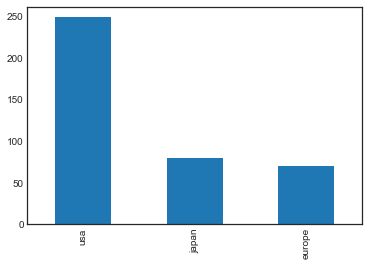

In [3]:
df["origin"].value_counts().plot(kind="bar")
# only 3 different categories

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


In [5]:
df.query('horsepower.isna()') 
# note that we coud use a regression model to fill in the missing values 
# if the error of the regression model isn't too large 

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
32,25.0,4,98.0,NaN,2046,19.0,71,usa
126,21.0,6,200.0,NaN,2875,17.0,74,usa
330,40.9,4,85.0,NaN,1835,17.3,80,europe
336,23.6,4,140.0,NaN,2905,14.3,80,usa
354,34.5,4,100.0,NaN,2320,15.8,81,europe
374,23.0,4,151.0,NaN,3035,20.5,82,usa


In [6]:
# to simplify we drop the NaNs 
df.dropna(inplace=True, axis = 0)

<AxesSubplot:>

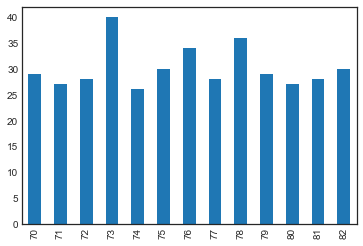

In [8]:
df["model_year"].value_counts().sort_index().plot(kind="bar")
# 13 categories -> one hot encode would create many more dimensions
# an idea is to group the years e.g. 70-73, 74-77, 78-82 or other group that could be useful if combined with
# domain knowledge

In [9]:
bins = pd.IntervalIndex.from_tuples([(69, 73), (74,77), (78,82)])

df["model_year"] = pd.cut(df["model_year"], bins=bins)

df = pd.get_dummies(df, columns = ["model_year", "origin"], drop_first=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,"model_year_(74, 77]","model_year_(78, 82]",origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,0,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,0,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,0,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,0,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,0,0,0,1


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# very important to pick out the values as keras can work with arrays but not DataFrames
X, y = df.drop("mpg", axis = 1).values, df["mpg"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((274, 9), (118, 9))

In [11]:
scaled_X_train.max()

3.2869431314281545

In [12]:
from sklearn.linear_model import LinearRegression

model_linear_regression = LinearRegression()
model_linear_regression.fit(scaled_X_train, y_train)

intercept, coefficients = model_linear_regression.intercept_, model_linear_regression.coef_
coefficients

array([-0.07963534,  0.71698622, -1.5802261 , -4.49219087, -0.08849455,
        0.36793355,  2.76523073,  0.02957218, -1.25074873])

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import SGD

model_shallow = Sequential(name="Shallow_network")
# one node per feature
model_shallow.add(InputLayer(X_train.shape[1], name="Input_layer"))
# one output node for one value, no activation is same as linear activation
model_shallow.add(Dense(1, name="Output_layer"))
model_shallow.compile(loss="mean_squared_error",
                      optimizer=SGD(learning_rate=.01))
model_shallow.summary()

Model: "Shallow_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output_layer (Dense)        (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit to training data 
model_shallow.fit(scaled_X_train, y_train, epochs = 50, verbose=0,
                  validation_data=(scaled_X_test, y_test))

# note that we don't use the test loss in this case to change any hyperparameters
# hence it is okay to use test in the validation_data here 
# for this dataset it would be better to use cross-validation for hyperparameter tuning as 
# we don't have much data

<AxesSubplot:title={'center':'Training loss and test loss'}, xlabel='Epochs', ylabel='Loss'>

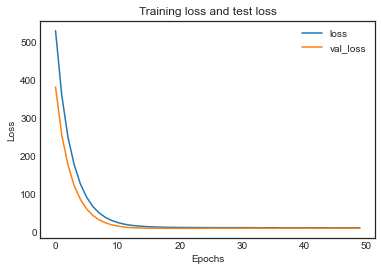

In [15]:
pd.DataFrame(model_shallow.history.history).plot(xlabel="Epochs",
                                                 ylabel="Loss", title="Training loss and test loss")
# this result shows no overfitting as both training loss and validation loss converges

In [16]:
weights, bias = model_shallow.layers[0].get_weights()

print(f"Linear regression {coefficients=}")
print(f"Shallow ANN {weights=}")
print(f"Linear regression {intercept=}")
print(f"Shallow ANN {bias=}")

# we see that the intercept is very similar value of linear regression and our shallow ANN.
# also the intercept is much larger than the weights and has larger impact in this case 
# in fact when we don't have any hidden layers and no non-linear activation funtion our ANN is performing 
# linear regression. 

Linear regression coefficients=array([-0.07963534,  0.71698622, -1.5802261 , -4.49219087, -0.08849455,
        0.36793355,  2.76523073,  0.02957218, -1.25074873])
Shallow ANN weights=array([[-0.444096  ],
       [-0.77139235],
       [-1.8334711 ],
       [-2.7736928 ],
       [-0.41437334],
       [ 0.21286224],
       [ 2.623347  ],
       [ 0.26408803],
       [-0.94424564]], dtype=float32)
Linear regression intercept=23.637591240875913
Shallow ANN bias=array([23.647469], dtype=float32)


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


def evaluate_regression(y_pred):
    mse = mean_squared_error(y_test, y_pred)
    return mean_absolute_error(y_test, y_pred), mse, np.sqrt(mse)


y_pred_ANN = model_shallow.predict(scaled_X_test)
y_pred_lin_reg = model_linear_regression.predict(scaled_X_test)

scores = {model: evaluate_regression(y_pred) for model, y_pred in zip(
    ["ANN", "Linear regression"], [y_pred_ANN, y_pred_lin_reg])}

df_scores = pd.DataFrame(scores, index=["MAE", "MSE", "RMSE"]).T
# compute proportion of RMSE error with respect to the mean of test data
df_scores["RMSE_proportion"] = df_scores["RMSE"]/y_test.mean()
df_scores

,MAE,MSE,RMSE,RMSE_proportion
ANN,2.571194,10.397107,3.224455,0.140189
Linear regression,2.522334,9.742016,3.121220,0.135700
